# Sentiment Analysis by ngrams and output_mode



## 將單字視為一組集合：詞袋法 (bag-of-words）

### 準備IMDB影評資料

In [ ]:
!curl -O https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xf aclImdb_v1.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 80.2M  100 80.2M    0     0  4103k      0  0:00:20  0:00:20 --:--:-- 5618k


In [ ]:
!rm -r aclImdb/train/unsup

In [ ]:
!cat aclImdb/train/pos/10000_8.txt  ##查看文字檔10000_8.txt的內容

Homelessness (or Houselessness as George Carlin stated) has been an issue for years but never a plan to help those on the street that were once considered human who did everything from going to school, work, or vote for the matter. Most people think of the homeless as just a lost cause while worrying about things such as racism, the war on Iraq, pressuring kids to succeed, technology, the elections, inflation, or worrying if they'll be next to end up on the streets.<br /><br />But what if you were given a bet to live on the streets for a month without the luxuries you once had from a home, the entertainment sets, a bathroom, pictures on the wall, a computer, and everything you once treasure to see what it's like to be homeless? That is Goddard Bolt's lesson.<br /><br />Mel Brooks (who directs) who stars as Bolt plays a rich man who has everything in the world until deciding to make a bet with a sissy rival (Jeffery Tambor) to see if he can live in the streets for thirty days without th

In [ ]:
import os, pathlib, shutil, random

base_dir = pathlib.Path("aclImdb")
val_dir = base_dir / "val"
train_dir = base_dir / "train"
for category in ("neg", "pos"):
    os.makedirs(val_dir / category)
    files = os.listdir(train_dir / category)
    random.Random(1357).shuffle(files)  ##用固定的隨機種子(1357)對訓練文件串列進行洗牌，以確保每次運行程式碼時都會得到相同的驗證集
    num_val_samples = int(0.2 * len(files))  ##取20%的訓練檔案以用於驗證
    val_files = files[-num_val_samples:]
    for fname in val_files:
        shutil.move(train_dir / category / fname,  ##將檔案移到aclImdb/val/neg和aclImdb/val/pos
                    val_dir / category / fname)

In [ ]:
from tensorflow import keras
batch_size = 32

train_ds = keras.utils.text_dataset_from_directory(  ##該行程式應該要輸出"Found 20000 files belonging to 2 classes"，如果你看到的是
                             ##"Found 70000 files belonging to 3 classes"，代表你忘了刪除aclImdb/train/unsup目錄
    "aclImdb/train", batch_size=batch_size
)
val_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/val", batch_size=batch_size
)
test_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/test", batch_size=batch_size
)

Found 20000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.
Found 25000 files belonging to 2 classes.


### 用TextVectorization層預先處理資料集 - multi_hot & 1_grams

In [ ]:
from tensorflow.keras.layers import TextVectorization
text_vectorization = TextVectorization(
    ngrams = 1,
    max_tokens=20000,  ##限制使用20000個最常出現的單字。若未指定則預設會為訓練資料中的每個單字建立索引，但這樣可能會多出幾萬個只出現一兩次的詞彙，
               ##而這些詞彙通常沒有乘載什麼有用的資訊。一般來說20000是做文字分類時的合理詞彙量
    output_mode="multi_hot"  ##將輸出token編碼成multi-hot二元向量
)

text_only_train_ds = train_ds.map(lambda x, y: x)  ##準備一個只產生原始文字輸入的資料集(沒有標籤)，為了將文字傳入TextVectorization以產生詞彙表
text_vectorization.adapt(text_only_train_ds)  ##使用"adapt"指令並以"text_only_train_ds"來建立索引

multi_hot_1grams_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y),  ##對文字資料進行預先處理
    num_parallel_calls=4)  ##明確指定num_parallel_calls值來使用多個CPU核心
multi_hot_1grams_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
multi_hot_1grams_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

def get_model(max_tokens=20000, hidden_dim=16):
    inputs = keras.Input(shape=(max_tokens,))
    x = layers.Dense(hidden_dim, activation="relu")(inputs)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inputs, outputs)
    model.compile(optimizer="rmsprop",
           loss="binary_crossentropy",
           metrics=["accuracy"])
    return model

In [ ]:
model = get_model()
model.summary()

callbacks = [
    keras.callbacks.ModelCheckpoint("multi_hot_1grams",
                    save_best_only=True)
]
history_multi_hot_1grams = model.fit(multi_hot_1grams_train_ds.cache(),  ##呼叫cache()以在記憶體中對資料集進行快取，這樣一來就只會在第一個epoch中進行預先處理，並在接下來的epoch中
                      ##重複使用預先處理完的文字(這個做法只有在資料量小到能裝進記憶體時才適用)
          validation_data=multi_hot_1grams_val_ds.cache(),
          epochs=30,
          callbacks=callbacks)

model = keras.models.load_model("multi_hot_1grams")
print(f"Test acc: {model.evaluate(multi_hot_1grams_test_ds)[1]:.3f}")

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 20000)]           0         
                                                                 
 dense_8 (Dense)             (None, 16)                320016    
                                                                 
 dropout_4 (Dropout)         (None, 16)                0         
                                                                 
 dense_9 (Dense)             (None, 1)                 17        
                                                                 
Total params: 320033 (1.22 MB)
Trainable params: 320033 (1.22 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/30
625/625 [==============================] - 3s 5ms/step - loss: 0.4045 - accuracy: 0.8316 - val_loss: 0.2815 - val_accuracy: 0.8922
Epoch 2/30
62

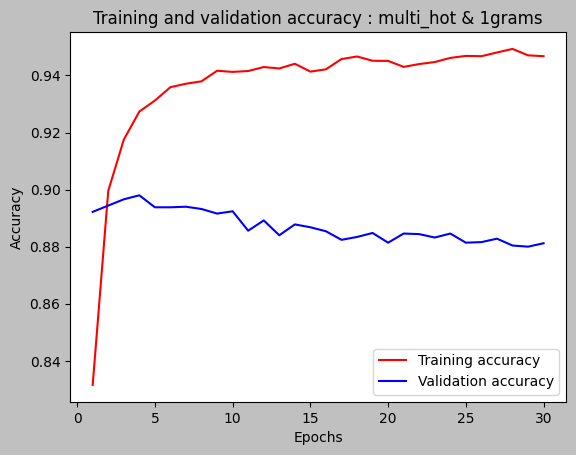

In [ ]:
import matplotlib.pyplot as plt

acc = history_multi_hot_1grams.history["accuracy"]
val_acc = history_multi_hot_1grams.history["val_accuracy"]
epochs = range(1, len(val_acc) + 1)
plt.gcf().set_facecolor('silver')
plt.plot(epochs, acc, "r", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy : multi_hot & 1grams")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [ ]:
print(acc)
print(val_acc)

[0.8315500020980835, 0.8995500206947327, 0.9175000190734863, 0.9273499846458435, 0.9312000274658203, 0.9358999729156494, 0.9370999932289124, 0.9379500150680542, 0.9416499733924866, 0.9412500262260437, 0.9415500164031982, 0.9429500102996826, 0.9424499869346619, 0.944100022315979, 0.941349983215332, 0.9421499967575073, 0.9457499980926514, 0.9466500282287598, 0.9451500177383423, 0.9451000094413757, 0.9430000185966492, 0.9440000057220459, 0.9447000026702881, 0.946150004863739, 0.9468500018119812, 0.9467499852180481, 0.9480500221252441, 0.9492999911308289, 0.9470499753952026, 0.9467499852180481]
[0.8921999931335449, 0.8944000005722046, 0.8966000080108643, 0.8980000019073486, 0.8938000202178955, 0.8938000202178955, 0.8939999938011169, 0.8931999802589417, 0.8916000127792358, 0.8924000263214111, 0.8855999708175659, 0.88919997215271, 0.8840000033378601, 0.8877999782562256, 0.8867999911308289, 0.8853999972343445, 0.8823999762535095, 0.883400022983551, 0.8848000168800354, 0.8813999891281128, 0.88

### 用TextVectorization層預先處理資料集 - multi_hot & 2_grams

In [ ]:
from tensorflow.keras.layers import TextVectorization
text_vectorization = TextVectorization(
    ngrams = 2,
    max_tokens=20000,  ##限制使用20000個最常出現的單字。若未指定則預設會為訓練資料中的每個單字建立索引，但這樣可能會多出幾萬個只出現一兩次的詞彙，
               ##而這些詞彙通常沒有乘載什麼有用的資訊。一般來說20000是做文字分類時的合理詞彙量
    output_mode="multi_hot"  ##將輸出token編碼成multi-hot二元向量
)

text_only_train_ds = train_ds.map(lambda x, y: x)  ##準備一個只產生原始文字輸入的資料集(沒有標籤)，為了將文字傳入TextVectorization以產生詞彙表
text_vectorization.adapt(text_only_train_ds)  ##使用"adapt"指令並以"text_only_train_ds"來建立索引

multi_hot_2grams_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y),  ##對文字資料進行預先處理
    num_parallel_calls=4)  ##明確指定num_parallel_calls值來使用多個CPU核心
multi_hot_2grams_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
multi_hot_2grams_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

def get_model(max_tokens=20000, hidden_dim=16):
    inputs = keras.Input(shape=(max_tokens,))
    x = layers.Dense(hidden_dim, activation="relu")(inputs)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inputs, outputs)
    model.compile(optimizer="rmsprop",
           loss="binary_crossentropy",
           metrics=["accuracy"])
    return model

In [ ]:
model = get_model()
model.summary()

callbacks = [
    keras.callbacks.ModelCheckpoint("multi_hot_2grams",
                                    save_best_only=True)
]
history_multi_hot_2grams = model.fit(multi_hot_2grams_train_ds.cache(),  ##呼叫cache()以在記憶體中對資料集進行快取，這樣一來就只會在第一個epoch中進行預先處理，
                                      ##並在接下來的epoch中重複使用預先處理完的文字(這個做法只有在資料量小到能裝進記憶體時才適用)
          validation_data=multi_hot_2grams_val_ds.cache(),
          epochs=30,
          callbacks=callbacks)

model = keras.models.load_model("multi_hot_2grams")
print(f"Test acc: {model.evaluate(multi_hot_2grams_test_ds)[1]:.3f}")

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 20000)]           0         
                                                                 
 dense_10 (Dense)            (None, 16)                320016    
                                                                 
 dropout_5 (Dropout)         (None, 16)                0         
                                                                 
 dense_11 (Dense)            (None, 1)                 17        
                                                                 
Total params: 320033 (1.22 MB)
Trainable params: 320033 (1.22 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/30
625/625 [==============================] - 4s 5ms/step - loss: 0.3890 - accuracy: 0.8353 - val_loss: 0.2580 - val_accuracy: 0.8952
Epoch 2/30
62

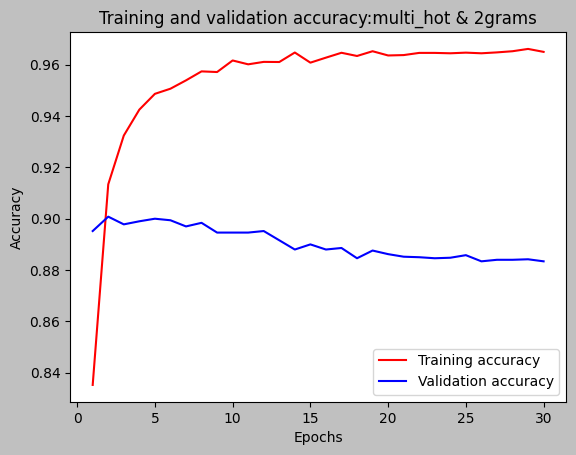

In [ ]:
import matplotlib.pyplot as plt

acc = history_multi_hot_2grams.history["accuracy"]
val_acc = history_multi_hot_2grams.history["val_accuracy"]
epochs = range(1, len(val_acc) + 1)
plt.gcf().set_facecolor('silver')
plt.plot(epochs, acc, "r", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy:multi_hot & 2grams")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [ ]:
print(acc)
print(val_acc)

[0.8352500200271606, 0.9133999943733215, 0.9323999881744385, 0.9424999952316284, 0.9486500024795532, 0.9506499767303467, 0.9538999795913696, 0.9574000239372253, 0.9571499824523926, 0.961650013923645, 0.9601500034332275, 0.9610999822616577, 0.9610499739646912, 0.9647499918937683, 0.9607999920845032, 0.9627500176429749, 0.9646499752998352, 0.9634000062942505, 0.9652500152587891, 0.9635999798774719, 0.9637500047683716, 0.9646000266075134, 0.9646000266075134, 0.9644500017166138, 0.9646999835968018, 0.9644500017166138, 0.9648000001907349, 0.9652500152587891, 0.9661499857902527, 0.9649999737739563]
[0.8952000141143799, 0.9007999897003174, 0.8978000283241272, 0.8989999890327454, 0.8999999761581421, 0.899399995803833, 0.8970000147819519, 0.8984000086784363, 0.894599974155426, 0.894599974155426, 0.894599974155426, 0.8952000141143799, 0.8916000127792358, 0.8880000114440918, 0.8899999856948853, 0.8880000114440918, 0.8885999917984009, 0.8845999836921692, 0.8876000046730042, 0.8862000107765198, 0.8

### 用TextVectorization層預先處理資料集 - count & 2_grams

In [ ]:
from tensorflow.keras.layers import TextVectorization
text_vectorization = TextVectorization(
    ngrams = 2,
    max_tokens=20000,  ##限制使用20000個最常出現的單字。若未指定則預設會為訓練資料中的每個單字建立索引，但這樣可能會多出幾萬個只出現一兩次的詞彙，
               ##而這些詞彙通常沒有乘載什麼有用的資訊。一般來說20000是做文字分類時的合理詞彙量
    output_mode="count"  ##將輸出token編碼成multi-hot二元向量
)

text_only_train_ds = train_ds.map(lambda x, y: x)  ##準備一個只產生原始文字輸入的資料集(沒有標籤)，為了將文字傳入TextVectorization以產生詞彙表
text_vectorization.adapt(text_only_train_ds)  ##使用"adapt"指令並以"text_only_train_ds"來建立索引

count_2grams_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y),  ##對文字資料進行預先處理
    num_parallel_calls=4)  ##明確指定num_parallel_calls值來使用多個CPU核心
count_2grams_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
count_2grams_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

def get_model(max_tokens=20000, hidden_dim=16):
    inputs = keras.Input(shape=(max_tokens,))
    x = layers.Dense(hidden_dim, activation="relu")(inputs)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inputs, outputs)
    model.compile(optimizer="rmsprop",
           loss="binary_crossentropy",
           metrics=["accuracy"])
    return model

In [ ]:
model = get_model()
model.summary()

callbacks = [
    keras.callbacks.ModelCheckpoint("count_2grams",
                                    save_best_only=True)
]
history_count_2grams = model.fit(count_2grams_train_ds.cache(),  ##呼叫cache()以在記憶體中對資料集進行快取，這樣一來就只會在第一個epoch中進行預先處理，並在接下來的epoch中
                      ##重複使用預先處理完的文字(這個做法只有在資料量小到能裝進記憶體時才適用)
          validation_data=count_2grams_val_ds.cache(),
          epochs=30,
          callbacks=callbacks)

model = keras.models.load_model("count_2grams")
print(f"Test acc: {model.evaluate(count_2grams_test_ds)[1]:.3f}")

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 20000)]           0         
                                                                 
 dense_4 (Dense)             (None, 16)                320016    
                                                                 
 dropout_2 (Dropout)         (None, 16)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 17        
                                                                 
Total params: 320033 (1.22 MB)
Trainable params: 320033 (1.22 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/30
625/625 [==============================] - 4s 5ms/step - loss: 0.4390 - accuracy: 0.8080 - val_loss: 0.3010 - val_accuracy: 0.8748
Epoch 2/30
62

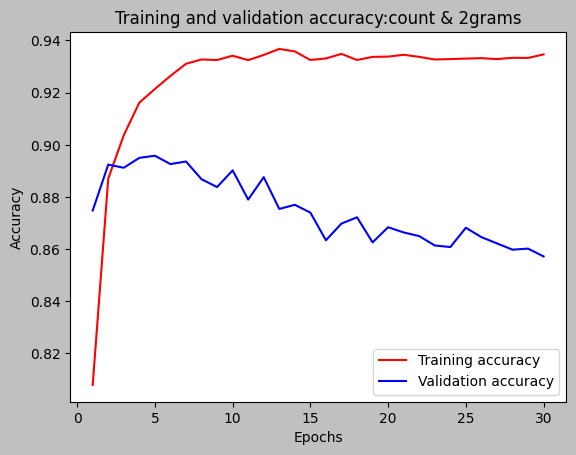

In [ ]:
import matplotlib.pyplot as plt

acc = history_count_2grams.history["accuracy"]
val_acc = history_count_2grams.history["val_accuracy"]
epochs = range(1, len(val_acc) + 1)
plt.gcf().set_facecolor('silver')
plt.plot(epochs, acc, "r", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy:count & 2grams")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [ ]:
print(acc)
print(val_acc)

[0.8079500198364258, 0.8870499730110168, 0.9036999940872192, 0.9161499738693237, 0.9214000105857849, 0.9264000058174133, 0.9310500025749207, 0.932699978351593, 0.9325000047683716, 0.934149980545044, 0.932449996471405, 0.9344499707221985, 0.9367499947547913, 0.9358000159263611, 0.9325000047683716, 0.9330999851226807, 0.9348499774932861, 0.9325000047683716, 0.9337000250816345, 0.9337999820709229, 0.934499979019165, 0.9337000250816345, 0.932699978351593, 0.9328500032424927, 0.9330499768257141, 0.9332000017166138, 0.9328500032424927, 0.9333500266075134, 0.9333000183105469, 0.9346500039100647]
[0.8748000264167786, 0.8924000263214111, 0.8912000060081482, 0.8949999809265137, 0.895799994468689, 0.8925999999046326, 0.8935999870300293, 0.8867999911308289, 0.8838000297546387, 0.8902000188827515, 0.8790000081062317, 0.8876000046730042, 0.8754000067710876, 0.8769999742507935, 0.8740000128746033, 0.8633999824523926, 0.8697999715805054, 0.8722000122070312, 0.8626000285148621, 0.868399977684021, 0.866

### 用TextVectorization層預先處理資料集 - tf_idf & 2 grams

In [ ]:
from tensorflow.keras.layers import TextVectorization
text_vectorization = TextVectorization(
    ngrams = 2,
    max_tokens=20000,  ##限制使用20000個最常出現的單字。若未指定則預設會為訓練資料中的每個單字建立索引，但這樣可能會多出幾萬個只出現一兩次的詞彙，
               ##而這些詞彙通常沒有乘載什麼有用的資訊。一般來說20000是做文字分類時的合理詞彙量
    output_mode="tf_idf"  ##將輸出token編碼成multi-hot二元向量
)
text_only_train_ds = train_ds.map(lambda x, y: x)  ##準備一個只產生原始文字輸入的資料集(沒有標籤)，為了將文字傳入TextVectorization以產生詞彙表
text_vectorization.adapt(text_only_train_ds)  ##使用"adapt"指令並以"text_only_train_ds"來建立索引

tf_idf_2grams_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y),  ##對文字資料進行預先處理
    num_parallel_calls=4)  ##明確指定num_parallel_calls值來使用多個CPU核心
tf_idf_2grams_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
tf_idf_2grams_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

def get_model(max_tokens=20000, hidden_dim=16):
    inputs = keras.Input(shape=(max_tokens,))
    x = layers.Dense(hidden_dim, activation="relu")(inputs)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inputs, outputs)
    model.compile(optimizer="rmsprop",
           loss="binary_crossentropy",
           metrics=["accuracy"])
    return model

In [ ]:
model = get_model()
model.summary()

callbacks = [
    keras.callbacks.ModelCheckpoint("tf_idf_2grams",
                                    save_best_only=True)
]
history_tf_idf_2grams = model.fit(tf_idf_2grams_train_ds.cache(),  ##呼叫cache()以在記憶體中對資料集進行快取，這樣一來就只會在第一個epoch中進行預先處理，並在接下來的epoch中
                      ##重複使用預先處理完的文字(這個做法只有在資料量小到能裝進記憶體時才適用)
          validation_data=tf_idf_2grams_val_ds.cache(),
          epochs=30,
          callbacks=callbacks)

model = keras.models.load_model("tf_idf_2grams")
print(f"Test acc: {model.evaluate(tf_idf_2grams_test_ds)[1]:.3f}")

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 20000)]           0         
                                                                 
 dense_6 (Dense)             (None, 16)                320016    
                                                                 
 dropout_3 (Dropout)         (None, 16)                0         
                                                                 
 dense_7 (Dense)             (None, 1)                 17        
                                                                 
Total params: 320033 (1.22 MB)
Trainable params: 320033 (1.22 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/30
625/625 [==============================] - 4s 5ms/step - loss: 0.5116 - accuracy: 0.7761 - val_loss: 0.2952 - val_accuracy: 0.8826
Epoch 2/30
62

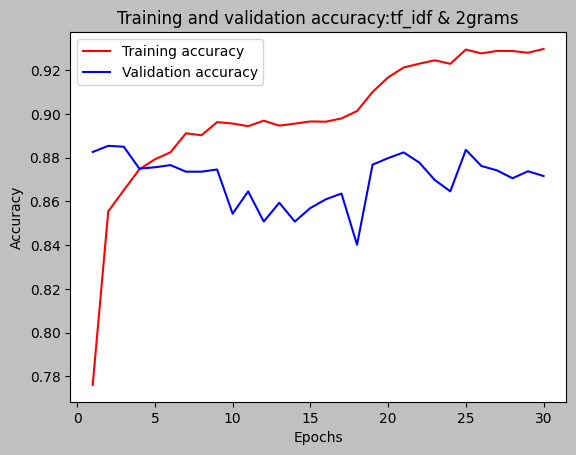

In [ ]:
import matplotlib.pyplot as plt

acc = history_tf_idf_2grams.history["accuracy"]
val_acc = history_tf_idf_2grams.history["val_accuracy"]
epochs = range(1, len(val_acc) + 1)
plt.gcf().set_facecolor('silver')
plt.plot(epochs, acc, "r", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy:tf_idf & 2grams")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [ ]:
print(acc)
print(val_acc)

[0.7761499881744385, 0.8554499745368958, 0.865149974822998, 0.8746500015258789, 0.8792499899864197, 0.8824499845504761, 0.8911499977111816, 0.890250027179718, 0.8962500095367432, 0.8956000208854675, 0.8944000005722046, 0.8968999981880188, 0.8946499824523926, 0.895550012588501, 0.8965499997138977, 0.8964499831199646, 0.8979499936103821, 0.9013000130653381, 0.9100499749183655, 0.916700005531311, 0.9211999773979187, 0.922950029373169, 0.9244999885559082, 0.9229000210762024, 0.9294000267982483, 0.927649974822998, 0.9287999868392944, 0.9287499785423279, 0.9279500246047974, 0.9297000169754028]
[0.8826000094413757, 0.8853999972343445, 0.8849999904632568, 0.875, 0.8755999803543091, 0.8766000270843506, 0.8736000061035156, 0.8736000061035156, 0.8745999932289124, 0.8543999791145325, 0.8646000027656555, 0.8507999777793884, 0.8593999743461609, 0.8507999777793884, 0.8569999933242798, 0.8610000014305115, 0.8636000156402588, 0.8402000069618225, 0.876800000667572, 0.879800021648407, 0.8823999762535095,

### 在不同tokens的編碼方式下，畫出驗證集的accuracy做比較

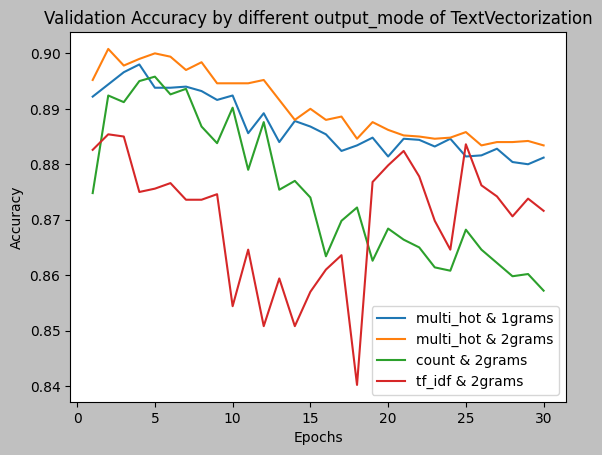

In [ ]:
import matplotlib.pyplot as plt

val_acc_multi_hot_1grams = history_multi_hot_1grams.history["val_accuracy"]
val_acc_multi_hot_2grams = history_multi_hot_2grams.history["val_accuracy"]
val_acc_count_2grams = history_count_2grams.history["val_accuracy"]
val_acc_tf_idf_2grams = history_tf_idf_2grams.history["val_accuracy"]

epochs = range(1, len(val_acc) + 1)
plt.gcf().set_facecolor('silver')
plt.plot(epochs, val_acc_multi_hot_1grams, label="multi_hot & 1grams")
plt.plot(epochs, val_acc_multi_hot_2grams,  label="multi_hot & 2grams")
plt.plot(epochs, val_acc_count_2grams,  label="count & 2grams")
plt.plot(epochs, val_acc_tf_idf_2grams,  label="tf_idf & 2grams")

plt.title("Validation Accuracy by different output_mode of TextVectorization")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

#Sentiment Analysis by embeddings

## 將單字視為序列:序列模型(sequence model)的編碼方式

### 用TextVectorization層預先處理資料集 - int & no mask & oen_hot embedding

In [ ]:
from tensorflow.keras import layers

max_length = 600
max_tokens = 20000
text_vectorization = layers.TextVectorization(
    ngrams = 1,
    max_tokens=max_tokens,
    output_mode="int",
    output_sequence_length=max_length,  ##為了控制輸入大小，我們只會擷取評論中的前600個單字。這是一個很合理的做法，
                       ##因為影評的平均長度為233字，只有5%的評論會超過600字
)

text_only_train_ds = train_ds.map(lambda x, y: x)
text_vectorization.adapt(text_only_train_ds)

int_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
int_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
int_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)

In [ ]:
import tensorflow as tf

inputs = keras.Input(shape=(None,), dtype="int64")  ##一筆輸入就是一個整數序列(None表示序列長度不固定，不過本例實際輸出的序列長度均為600)
embedded = tf.one_hot(inputs, depth=max_tokens)  ##將每個整數值都編碼為20000維(最大tokens數為20000)的one-hot向量(embedded的shape為(batch,600,20000))，
                           ##即將原本的整數序列改為獨熱編碼
x = layers.Bidirectional(layers.LSTM(32))(embedded)  ##添加一個雙向LSTM
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)  ##最後，添加一個用作分類的Dense層
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
       loss="binary_crossentropy",
       metrics=["accuracy"])

model.summary()

callbacks = [
    keras.callbacks.ModelCheckpoint("int_one_hot_bidir_lstm",
                    save_best_only=True)
]
history_int_one_hot_bidir_lstm = model.fit(int_train_ds, validation_data=int_val_ds, epochs=30, callbacks=callbacks)

model = keras.models.load_model("int_one_hot_bidir_lstm")
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None)]            0         
                                                                 
 tf.one_hot_1 (TFOpLambda)   (None, None, 20000)       0         
                                                                 
 bidirectional_3 (Bidirecti  (None, 64)                5128448   
 onal)                                                           
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 5128513 (19.56 MB)
Trainable params: 5128513 (19.56 MB)
Non-trainable params: 0 (0.00 Byte)
___________________

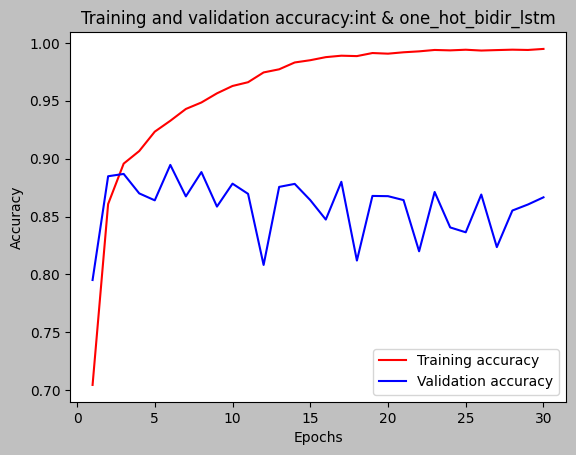

In [ ]:
import matplotlib.pyplot as plt

acc = history_int_one_hot_bidir_lstm.history["accuracy"]
val_acc = history_int_one_hot_bidir_lstm.history["val_accuracy"]
epochs = range(1, len(val_acc) + 1)
plt.gcf().set_facecolor('silver')
plt.plot(epochs, acc, "r", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy:int & one_hot_bidir_lstm")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [ ]:
print(acc)
print(val_acc)

[0.7045999765396118, 0.86080002784729, 0.8956999778747559, 0.9065499901771545, 0.92330002784729, 0.932699978351593, 0.9429000020027161, 0.9484999775886536, 0.9563999772071838, 0.9627500176429749, 0.9660000205039978, 0.9744499921798706, 0.977150022983551, 0.9830499887466431, 0.9850000143051147, 0.9876499772071838, 0.9889000058174133, 0.9885500073432922, 0.9911999702453613, 0.9906499981880188, 0.9918500185012817, 0.9926499724388123, 0.9938499927520752, 0.9934999942779541, 0.9940500259399414, 0.9933500289916992, 0.9937499761581421, 0.9940999746322632, 0.9938499927520752, 0.9947500228881836]
[0.795199990272522, 0.8848000168800354, 0.8867999911308289, 0.8700000047683716, 0.8640000224113464, 0.894599974155426, 0.8673999905586243, 0.8884000182151794, 0.8586000204086304, 0.8784000277519226, 0.8695999979972839, 0.8082000017166138, 0.8755999803543091, 0.8781999945640564, 0.8641999959945679, 0.8474000096321106, 0.8799999952316284, 0.8119999766349792, 0.8677999973297119, 0.8676000237464905, 0.8641

In [ ]:
##val_acc_int_one_hot_bidir_lstm = [0.795199990272522, 0.8848000168800354, 0.8867999911308289, 0.8700000047683716, 0.8640000224113464, 0.894599974155426, 0.8673999905586243, 0.8884000182151794, 0.8586000204086304, 0.8784000277519226, 0.8695999979972839, 0.8082000017166138, 0.8755999803543091, 0.8781999945640564, 0.8641999959945679, 0.8474000096321106, 0.8799999952316284, 0.8119999766349792, 0.8677999973297119, 0.8676000237464905, 0.8641999959945679, 0.8199999928474426, 0.8712000250816345, 0.8406000137329102, 0.8363999724388123, 0.8690000176429749, 0.8235999941825867, 0.8551999926567078, 0.8604000210762024, 0.866599977016449]

### 用TextVectorization層預先處理資料集 - int & no mask & tensorflow embedding

In [ ]:
from tensorflow.keras import layers

max_length = 600
max_tokens = 20000
text_vectorization = layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",
    output_sequence_length=max_length,  ##為了控制輸入大小，我們只會擷取評論中的前600個單字。這是一個很合理的做法，
                       ##因為影評的平均長度為233字，只有5%的評論會超過600字
)

text_only_train_ds = train_ds.map(lambda x, y: x)
text_vectorization.adapt(text_only_train_ds)

int_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
int_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
int_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)

In [ ]:
inputs = keras.Input(shape=(None,), dtype="int64")
embedded = layers.Embedding(input_dim=max_tokens, output_dim=256)(inputs)
x = layers.Bidirectional(layers.LSTM(32))(embedded)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
       loss="binary_crossentropy",
       metrics=["accuracy"])

model.summary()

callbacks = [
    keras.callbacks.ModelCheckpoint("int_embeddings_bidir_lstm",
    save_best_only=True)
]

history_int_embeddings_bidir_lstm = model.fit(int_train_ds, validation_data=int_val_ds, epochs=30, callbacks=callbacks)  ##原程式碼epochs為10

model = keras.models.load_model("int_embeddings_bidir_lstm")
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 256)         5120000   
                                                                 
 bidirectional_2 (Bidirecti  (None, 64)                73984     
 onal)                                                           
                                                                 
 dropout_8 (Dropout)         (None, 64)                0         
                                                                 
 dense_14 (Dense)            (None, 1)                 65        
                                                                 
Total params: 5194049 (19.81 MB)
Trainable params: 5194049 (19.81 MB)
Non-trainable params: 0 (0.00 Byte)
___________________

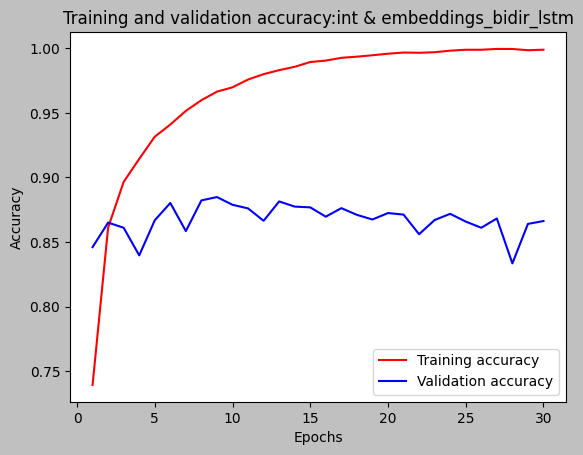

In [ ]:
import matplotlib.pyplot as plt

acc = history_int_embeddings_bidir_lstm.history["accuracy"]
val_acc = history_int_embeddings_bidir_lstm.history["val_accuracy"]
epochs = range(1, len(val_acc) + 1)
plt.gcf().set_facecolor('silver')
plt.plot(epochs, acc, "r", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy:int & embeddings_bidir_lstm")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [ ]:
print(acc)
print(val_acc)

[0.7392500042915344, 0.8611500263214111, 0.8965499997138977, 0.9143499732017517, 0.9315500259399414, 0.9409499764442444, 0.9515500068664551, 0.959850013256073, 0.9664499759674072, 0.9697999954223633, 0.975849986076355, 0.9800000190734863, 0.9830999970436096, 0.9857000112533569, 0.9894000291824341, 0.9904999732971191, 0.9926499724388123, 0.9935500025749207, 0.9946500062942505, 0.9958500266075134, 0.996749997138977, 0.9965500235557556, 0.996999979019165, 0.998199999332428, 0.9988999962806702, 0.9988999962806702, 0.9995499849319458, 0.9994999766349792, 0.9985499978065491, 0.9989500045776367]
[0.8460000157356262, 0.8650000095367432, 0.8610000014305115, 0.8396000266075134, 0.8668000102043152, 0.8802000284194946, 0.8583999872207642, 0.8822000026702881, 0.8848000168800354, 0.8787999749183655, 0.8759999871253967, 0.8664000034332275, 0.8813999891281128, 0.8773999810218811, 0.876800000667572, 0.8695999979972839, 0.8762000203132629, 0.8709999918937683, 0.8673999905586243, 0.8723999857902527, 0.87

In [ ]:
##val_acc_int_embeddings_bidir_lstm = [0.8460000157356262, 0.8650000095367432, 0.8610000014305115, 0.8396000266075134, 0.8668000102043152, 0.8802000284194946, 0.8583999872207642, 0.8822000026702881, 0.8848000168800354, 0.8787999749183655, 0.8759999871253967, 0.8664000034332275, 0.8813999891281128, 0.8773999810218811, 0.876800000667572, 0.8695999979972839, 0.8762000203132629, 0.8709999918937683, 0.8673999905586243, 0.8723999857902527, 0.8712000250816345, 0.8560000061988831, 0.8669999837875366, 0.8718000054359436, 0.8658000230789185, 0.8610000014305115, 0.8682000041007996, 0.8334000110626221, 0.8640000224113464, 0.8661999702453613]

### 用TextVectorization層預先處理資料集 - int & mask & tensorflow embedding

In [ ]:
from tensorflow.keras import layers

max_length = 600
max_tokens = 20000
text_vectorization = layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",
    output_sequence_length=max_length,  ##為了控制輸入大小，我們只會擷取評論中的前600個單字。這是一個很合理的做法，
                       ##因為影評的平均長度為233字，只有5%的評論會超過600字
)

text_only_train_ds = train_ds.map(lambda x, y: x)
text_vectorization.adapt(text_only_train_ds)

int_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
int_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
int_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)

In [ ]:
inputs = keras.Input(shape=(None,), dtype="int64")
embedded = layers.Embedding(
    input_dim=max_tokens, output_dim=256, mask_zero=True)(inputs)  ##"mask_zero=True":啟用遮罩
x = layers.Bidirectional(layers.LSTM(32))(embedded)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
       loss="binary_crossentropy",
       metrics=["accuracy"])

model.summary()
callbacks = [
    keras.callbacks.ModelCheckpoint("int_embeddings_bidir_lstm_with_masking",
                    save_best_only=True)
]

history_int_embeddings_bidir_lstm_with_masking = model.fit(int_train_ds, validation_data=int_val_ds, epochs=30, callbacks=callbacks)

model = keras.models.load_model("int_embeddings_bidir_lstm_with_masking")
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, None)]            0         
                                                                 
 embedding_1 (Embedding)     (None, None, 256)         5120000   
                                                                 
 bidirectional_3 (Bidirecti  (None, 64)                73984     
 onal)                                                           
                                                                 
 dropout_9 (Dropout)         (None, 64)                0         
                                                                 
 dense_15 (Dense)            (None, 1)                 65        
                                                                 
Total params: 5194049 (19.81 MB)
Trainable params: 5194049 (19.81 MB)
Non-trainable params: 0 (0.00 Byte)
___________________

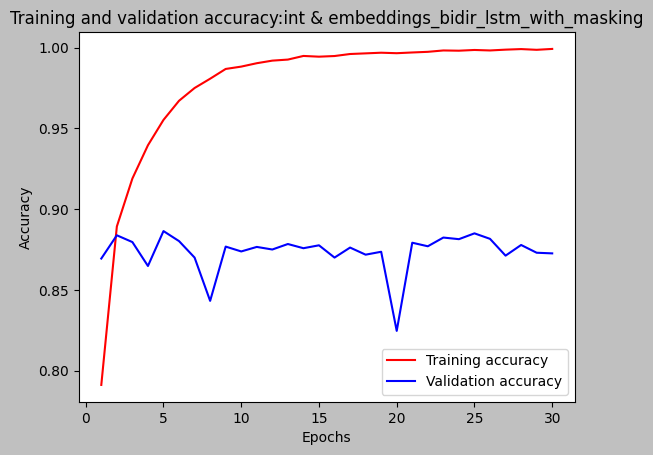

In [ ]:
import matplotlib.pyplot as plt

acc = history_int_embeddings_bidir_lstm_with_masking.history["accuracy"]
val_acc = history_int_embeddings_bidir_lstm_with_masking.history["val_accuracy"]
epochs = range(1, len(val_acc) + 1)
plt.gcf().set_facecolor('silver')
plt.plot(epochs, acc, "r", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy:int & embeddings_bidir_lstm_with_masking")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [ ]:
print(acc)
print(val_acc)

[0.7911499738693237, 0.8892499804496765, 0.9189500212669373, 0.93954998254776, 0.9552500247955322, 0.9671000242233276, 0.9750000238418579, 0.9807500243186951, 0.9868000149726868, 0.9882500171661377, 0.9903500080108643, 0.9919499754905701, 0.9926000237464905, 0.9948499798774719, 0.9944000244140625, 0.9947999715805054, 0.9960500001907349, 0.9964500069618225, 0.9968500137329102, 0.9965500235557556, 0.996999979019165, 0.9973999857902527, 0.9982500076293945, 0.9980999827384949, 0.9985499978065491, 0.9982500076293945, 0.9987499713897705, 0.9991000294685364, 0.9986500144004822, 0.9991999864578247]
[0.8694000244140625, 0.8838000297546387, 0.8795999884605408, 0.864799976348877, 0.8863999843597412, 0.8802000284194946, 0.8700000047683716, 0.8432000279426575, 0.876800000667572, 0.8737999796867371, 0.8766000270843506, 0.875, 0.8784000277519226, 0.8758000135421753, 0.8776000142097473, 0.8700000047683716, 0.8762000203132629, 0.8718000054359436, 0.8736000061035156, 0.8245999813079834, 0.87919998168945

In [ ]:
##val_acc_int_embeddings_bidir_lstm_with_masking = [0.8694000244140625, 0.8838000297546387, 0.8795999884605408, 0.864799976348877, 0.8863999843597412, 0.8802000284194946, 0.8700000047683716, 0.8432000279426575, 0.876800000667572, 0.8737999796867371, 0.8766000270843506, 0.875, 0.8784000277519226, 0.8758000135421753, 0.8776000142097473, 0.8700000047683716, 0.8762000203132629, 0.8718000054359436, 0.8736000061035156, 0.8245999813079834, 0.8791999816894531, 0.8769999742507935, 0.8823999762535095, 0.8813999891281128, 0.8849999904632568, 0.881600022315979, 0.8712000250816345, 0.8777999877929688, 0.8730000257492065, 0.8726000189781189]

### 用TextVectorization層預先處理資料集 - int & mask & GloVe embedding

In [ ]:
from tensorflow.keras import layers

max_length = 600
max_tokens = 20000
text_vectorization = layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",
    output_sequence_length=max_length,  ##為了控制輸入大小，我們只會擷取評論中的前600個單字。這是一個很合理的做法，
                       ##因為影評的平均長度為233字，只有5%的評論會超過600字
)

text_only_train_ds = train_ds.map(lambda x, y: x)
text_vectorization.adapt(text_only_train_ds)

int_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
int_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
int_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


到GloVe詞嵌入向量檔案進行解析

In [ ]:
import numpy as np
path_to_glove_file = "glove.6B.100d.txt"

embeddings_index = {}
with open('/content/drive/MyDrive/Colab Notebooks/glove.6B.100d.txt') as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print(f"Found {len(embeddings_index)} word vectors.")

Found 400000 word vectors.


準備GloVe詞嵌入矩陣

In [ ]:
embedding_dim = 100

vocabulary = text_vectorization.get_vocabulary()  ##取得之前使用TextVectorization層建立好的詞彙表，即取得來自IMDB影評資料的vocabulary
word_index = dict(zip(vocabulary, range(len(vocabulary))))  ##建立將單字對應到詞彙表中的索引的字典，即將IMDB影評資料的vocabulary轉為dict
      ##亦可使用dict(enumerate(vocabulary))來創建字典

embedding_matrix = np.zeros((max_tokens, embedding_dim))  ##準備一個空矩陣，用來存放每個單字的GloVe向量
for word, i in word_index.items():  ##走訪每一個單字(word)及其在詞彙表中的索引(i)
    if i < max_tokens:  ##max_tokens=20000
        embedding_vector = embeddings_index.get(word)  ##取得word對應到的GloVe向量(若沒有對應到的GloVe向量則傳回None)
                                  ##即以get指令，找出在text_vectorization與embeddings_index同時出現的單字，並給予詞向量
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector  ##將單字的GloVe向量存到嵌入矩陣中索引i的位置(若單字沒有對應GloVe向量則會略過，其值將為預設的全零向量)


In [ ]:
embedding_layer = layers.Embedding(
    max_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),  ##載入預訓練過的嵌入向量
    trainable=False,
    mask_zero=True,
)

使用預訓練Embedding層的模型

In [ ]:
inputs = keras.Input(shape=(None,), dtype="int64")
embedded = embedding_layer(inputs)
x = layers.Bidirectional(layers.LSTM(32))(embedded)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
       loss="binary_crossentropy",
       metrics=["accuracy"])

model.summary()
callbacks = [
    keras.callbacks.ModelCheckpoint("glove_embeddings",
                    save_best_only=True)
]

history_int_glove_embeddings = model.fit(int_train_ds, validation_data=int_val_ds, epochs=30, callbacks=callbacks)  ##原程式碼epochs為10

model = keras.models.load_model("glove_embeddings")
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, None)]            0         
                                                                 
 embedding_2 (Embedding)     (None, None, 100)         2000000   
                                                                 
 bidirectional_4 (Bidirecti  (None, 64)                34048     
 onal)                                                           
                                                                 
 dropout_10 (Dropout)        (None, 64)                0         
                                                                 
 dense_16 (Dense)            (None, 1)                 65        
                                                                 
Total params: 2034113 (7.76 MB)
Trainable params: 34113 (133.25 KB)
Non-trainable params: 2000000 (7.63 MB)
________________

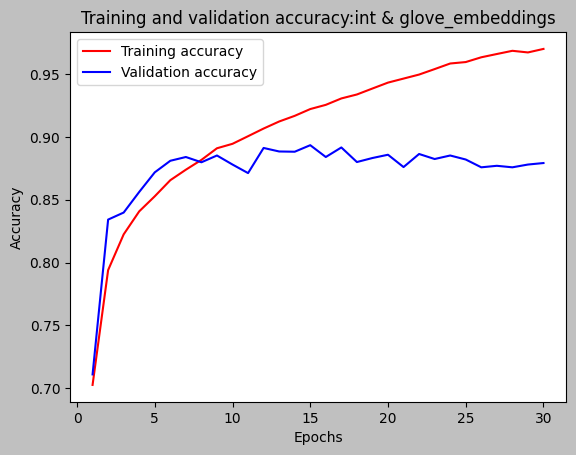

In [ ]:
import matplotlib.pyplot as plt

acc = history_int_glove_embeddings.history["accuracy"]
val_acc = history_int_glove_embeddings.history["val_accuracy"]
epochs = range(1, len(val_acc) + 1)
plt.gcf().set_facecolor('silver')
plt.plot(epochs, acc, "r", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy:int & glove_embeddings")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [ ]:
print(acc)
print(val_acc)

[0.7026500105857849, 0.7940000295639038, 0.8224499821662903, 0.840749979019165, 0.8527500033378601, 0.8655499815940857, 0.8738999962806702, 0.8816999793052673, 0.8909500241279602, 0.8945000171661377, 0.9005500078201294, 0.9066500067710876, 0.9122499823570251, 0.9167500138282776, 0.9221500158309937, 0.9254999756813049, 0.9305999875068665, 0.9337499737739563, 0.9384999871253967, 0.9431999921798706, 0.946399986743927, 0.9495999813079834, 0.9539499878883362, 0.9584000110626221, 0.9595500230789185, 0.9633499979972839, 0.9659500122070312, 0.968500018119812, 0.967199981212616, 0.9700000286102295]
[0.7110000252723694, 0.8342000246047974, 0.8398000001907349, 0.8561999797821045, 0.8718000054359436, 0.8809999823570251, 0.8840000033378601, 0.879800021648407, 0.885200023651123, 0.878000020980835, 0.8712000250816345, 0.8912000060081482, 0.8884000182151794, 0.8881999850273132, 0.8934000134468079, 0.8840000033378601, 0.8916000127792358, 0.8799999952316284, 0.8831999897956848, 0.8858000040054321, 0.875

In [ ]:
##val_acc_int_glove_embeddings = [0.7110000252723694, 0.8342000246047974, 0.8398000001907349, 0.8561999797821045, 0.8718000054359436, 0.8809999823570251, 0.8840000033378601, 0.879800021648407, 0.885200023651123, 0.878000020980835, 0.8712000250816345, 0.8912000060081482, 0.8884000182151794, 0.8881999850273132, 0.8934000134468079, 0.8840000033378601, 0.8916000127792358, 0.8799999952316284, 0.8831999897956848, 0.8858000040054321, 0.8759999871253967, 0.8863999843597412, 0.8823999762535095, 0.885200023651123, 0.8820000290870667, 0.8758000135421753, 0.8769999742507935, 0.8758000135421753, 0.878000020980835, 0.8791999816894531]

# 在不同tokens的編碼及embedding方式下，畫出驗證集的accuracy做比較

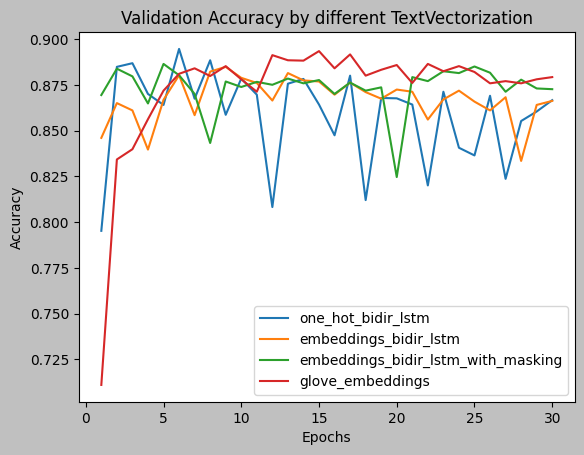

In [ ]:
import matplotlib.pyplot as plt

val_acc_int_one_hot_bidir_lstm = history_int_one_hot_bidir_lstm.history["val_accuracy"]
val_acc_int_embeddings_bidir_lstm = history_int_embeddings_bidir_lstm.history["val_accuracy"]
val_acc_int_embeddings_bidir_lstm_with_masking = history_int_embeddings_bidir_lstm_with_masking.history["val_accuracy"]
val_acc_int_glove_embeddings = history_int_glove_embeddings.history["val_accuracy"]

epochs = range(1, len(val_acc) + 1)
plt.gcf().set_facecolor('silver')
plt.plot(epochs, val_acc_int_one_hot_bidir_lstm, label="one_hot_bidir_lstm")
plt.plot(epochs, val_acc_int_embeddings_bidir_lstm, label="embeddings_bidir_lstm")
plt.plot(epochs, val_acc_int_embeddings_bidir_lstm_with_masking, label="embeddings_bidir_lstm_with_masking")
plt.plot(epochs, val_acc_int_glove_embeddings, label="glove_embeddings")

plt.title("Validation Accuracy by different TextVectorization")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# 用TextVectorization層預先處理資料集 - int & mask & word2vec embedding(google-news-news-300)

到word2vec-google-news-300詞嵌入向量檔案進行解析

In [ ]:
import gensim.downloader as api

# 下載Word2Vec模型
word2vec_model = api.load("word2vec-google-news-300")

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [ ]:
print(f"在word2vec-google-news-300中，共有{len(word2vec_model.index_to_key)}個詞向量")

在word2vec-google-news-300中，共有3000000個詞向量


In [ ]:
vocab_for_google_news = word2vec_model.index_to_key
embeddings_index = {}

for word in vocab_for_google_news:
  embeddings_index[word] = word2vec_model[word]

print(f"Found {len(embeddings_index)} word vectors.")

Found 3000000 word vectors.


準備word2vec-google-news-300詞嵌入矩陣

In [ ]:
import numpy as np
embedding_dim = 300

vocabulary = text_vectorization.get_vocabulary()  ##取得之前使用TextVectorization層建立好的詞彙表，即取得來自IMDB影評資料的vocabulary
word_index = dict(zip(vocabulary, range(len(vocabulary))))  ##建立將單字對應到詞彙表中的索引的字典，即將IMDB影評資料的vocabulary轉為dict
      ##亦可使用dict(enumerate(vocabulary))來創建字典

embedding_matrix = np.zeros((max_tokens, embedding_dim))  ##準備一個空矩陣，用來存放每個單字的word2vec向量
for word, i in word_index.items():  ##走訪每一個單字(word)及其在詞彙表中的索引(i)
    if i < max_tokens:  ##max_tokens=20000
        embedding_vector = embeddings_index.get(word)  ##取得word對應到的word2vec向量(若沒有對應到的word2vec向量則傳回None)
                                  ##即以get指令，找出在text_vectorization與embeddings_index同時出現的單字，並給予詞向量
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector  ##將單字的word2vec向量存到嵌入矩陣中索引i的位置(若單字沒有對應word2vec向量則會略過，其值將為預設的全零向量)


In [ ]:
embedding_layer = layers.Embedding(
    max_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),  ##載入預訓練過的嵌入向量
    trainable=False,
    mask_zero=True,
)

使用預訓練Embedding層的模型

In [ ]:
inputs = keras.Input(shape=(None,), dtype="int64")
embedded = embedding_layer(inputs)
x = layers.Bidirectional(layers.LSTM(32))(embedded)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
       loss="binary_crossentropy",
       metrics=["accuracy"])

model.summary()

callbacks = [
    keras.callbacks.ModelCheckpoint("word2vec_embeddings_google_news",
                    save_best_only=True)
]
history_int_word2vec_google_news = model.fit(int_train_ds, validation_data=int_val_ds, epochs=30, callbacks=callbacks)  ##原程式碼epochs為10

model = keras.models.load_model("word2vec_embeddings_google_news")
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_1 (Embedding)     (None, None, 300)         6000000   
                                                                 
 bidirectional_2 (Bidirecti  (None, 64)                85248     
 onal)                                                           
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 6085313 (23.21 MB)
Trainable params: 85313 (333.25 KB)
Non-trainable params: 6000000 (22.89 MB)
_______________

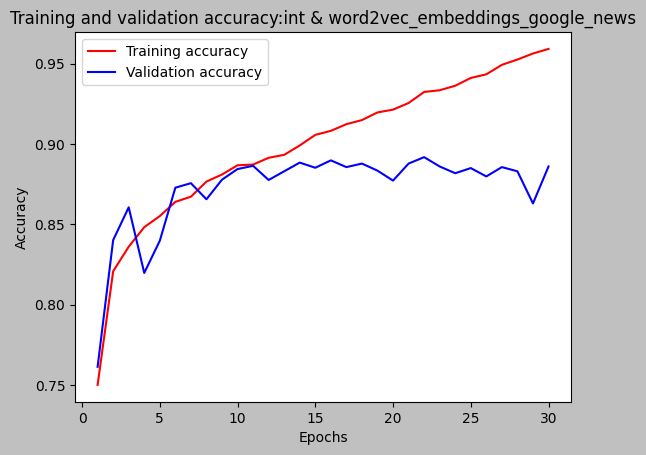

In [ ]:
import matplotlib.pyplot as plt

acc = history_int_word2vec_google_news.history["accuracy"]
val_acc = history_int_word2vec_google_news.history["val_accuracy"]
epochs = range(1, len(val_acc) + 1)
plt.gcf().set_facecolor('silver')
plt.plot(epochs, acc, "r", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy:int & word2vec_embeddings_google_news")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [ ]:
print(acc)
print(val_acc)

[0.7501500248908997, 0.8208000063896179, 0.8360999822616577, 0.8482499718666077, 0.8551499843597412, 0.8640000224113464, 0.8672000169754028, 0.8766000270843506, 0.8809999823570251, 0.8867499828338623, 0.8871999979019165, 0.8913999795913696, 0.8932499885559082, 0.8990499973297119, 0.9056500196456909, 0.9081500172615051, 0.9122999906539917, 0.9148499965667725, 0.9196000099182129, 0.9213500022888184, 0.9254500269889832, 0.9323499798774719, 0.9333999752998352, 0.9362000226974487, 0.9410499930381775, 0.9433000087738037, 0.9491999745368958, 0.9524999856948853, 0.956250011920929, 0.9591000080108643]
[0.7613999843597412, 0.8402000069618225, 0.8605999946594238, 0.8198000192642212, 0.8398000001907349, 0.8727999925613403, 0.8755999803543091, 0.8655999898910522, 0.8777999877929688, 0.8844000101089478, 0.8863999843597412, 0.8776000142097473, 0.8830000162124634, 0.8884000182151794, 0.885200023651123, 0.8898000121116638, 0.8855999708175659, 0.8877999782562256, 0.883400022983551, 0.8772000074386597, 0

In [ ]:
##val_acc_int_history_int_word2vec_google_news = [0.7613999843597412, 0.8402000069618225, 0.8605999946594238, 0.8198000192642212, 0.8398000001907349, 0.8727999925613403, 0.8755999803543091, 0.8655999898910522, 0.8777999877929688, 0.8844000101089478, 0.8863999843597412, 0.8776000142097473, 0.8830000162124634, 0.8884000182151794, 0.885200023651123, 0.8898000121116638, 0.8855999708175659, 0.8877999782562256, 0.883400022983551, 0.8772000074386597, 0.8877999782562256, 0.8917999863624573, 0.8859999775886536, 0.8817999958992004, 0.8849999904632568, 0.879800021648407, 0.8855999708175659, 0.8830000162124634, 0.8629999756813049, 0.8859999775886536]

# 用TextVectorization層預先處理資料集 - int & mask & word2vec embedding(IMDB)

In [ ]:
from tensorflow.keras import layers

max_length = 600
max_tokens = 20000
text_vectorization = layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",
    output_sequence_length=max_length,  ##為了控制輸入大小，我們只會擷取評論中的前600個單字。這是一個很合理的做法，
                       ##因為影評的平均長度為233字，只有5%的評論會超過600字
)

text_only_train_ds = train_ds.map(lambda x, y: x)
text_vectorization.adapt(text_only_train_ds)

int_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
int_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
int_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)

下載IMDB影評資料集

In [ ]:
from tensorflow.keras.preprocessing import sequence
from keras.datasets import imdb

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=20000)  ##載入 IMDB 影評資料集，限制單字數量20000

word_index = imdb.get_word_index()  ##下載詞彙字典

reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])  ##將單字索引與單字對應

def decode_review(review):
    return ' '.join([reverse_word_index.get(i - 3, "?") for i in review])  ##解碼影評文本

decoded_train_data = [decode_review(review) for review in train_data]  ##解碼訓練資料中的影評文本

print("解碼的訓練影評示例：", decoded_train_data[0])  ##輸出一個例子以確認是否成功解碼

1641221/1641221 [==============================] - 0s 0us/step
解碼的訓練影評示例： ? this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert ? is an amazing actor and now the same being director ? father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for retail and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also congratulations to the two little boy's that played the ? of norman and paul they were just brilliant children are often left out of the praising list i think because the stars that play them all grown up are such a big profile for the w

對文本做預處理操作

In [ ]:
from gensim.utils import simple_preprocess
processed_data = []

for sentences in decoded_train_data:
  processed_data.append(simple_preprocess(sentences))

simple_preprocess 是 Gensim 庫中的一個函數，用於對文本進行簡單的預處理操作。它的功能包括：

1.分詞：將文本拆分成單詞或標記的列表。默認情況下，它使用空格作為分詞器，但你也可以通過指定 tokenizer 參數來使用自定義的分詞器。  
2.轉換為小寫：將所有單詞轉換為小寫形式。這有助於統一單詞的形式，避免同一個單詞因為大小寫不同被認為是不同的單詞。  
3.去除標點符號：移除文本中的標點符號。標點符號通常對詞嵌入模型的訓練沒有幫助，因此可以被移除。  
4.去除停用詞：可選步驟，根據需要移除文本中的停用詞。停用詞是指對文本分析無意義或有很少實際意義的詞語，如 "的"、"是"、"和" 等。

以IMDB資料庫來訓練Word2Vec模型

In [ ]:
from gensim.models import Word2Vec

model = Word2Vec(sentences=processed_data, vector_size=300, window=5, min_count=1, workers=4)  ##初始化word2vec模型並進行訓練

word_vectors = model.wv  ##獲取詞向量
vocab = list(word_vectors.index_to_key)  ##獲取詞彙表

print("詞彙表:", vocab[:10])  ##輸出詞彙表中的前10個詞

vector = word_vectors["good"]  ##獲取某個詞的向量表示
print("good的向量表示:", vector)

詞彙表: ['the', 'and', 'of', 'to', 'is', 'br', 'it', 'in', 'this', 'that']
good的向量表示: [-1.4155633   0.50540525  0.18834288 -0.32047713 -0.09556247  0.8052552
  0.45401254 -0.6108738  -0.63372254  1.5016022  -0.74998385 -0.34946436
 -0.5202489  -1.7523897  -0.09425647 -0.47246087 -0.5618998  -0.6152253
 -0.43969446 -0.47113585 -0.05372712  0.35723707  1.865015    2.0458262
 -0.35891983  0.14726521 -0.02424222 -0.50130534 -0.61263704 -0.82149833
 -0.1419234   0.6754589  -0.22085509  0.3214048   0.10355719 -0.30639952
  0.7590695   0.6920177   0.0819409  -0.63057035  0.26938614 -1.200918
  1.3786396  -0.04505742 -1.1214839   0.7201189   0.19887684  0.7623427
 -0.572647    0.03199299 -1.1499622   0.2699788   0.8201489  -0.6442535
 -0.8256407   0.5281931  -0.26883486 -0.14258198  1.1191456   0.5268508
  0.41683322  0.46179795 -0.39881095  1.7692324   1.4547867  -1.2120757
 -1.6386523   0.31941682  1.3928635   1.0268519  -0.5995383  -0.19375636
  0.5549493  -1.4849311  -1.0602754   1.8661468   

In [ ]:
vocab_for_IMDB = vocab
embeddings_index = {}

for word in vocab_for_IMDB:
  embeddings_index[word] = word_vectors[word]

print(f"Found {len(embeddings_index)} word vectors.")

Found 18928 word vectors.


準備Word2Vec by IMDB詞嵌入矩陣

In [ ]:
import numpy as np
embedding_dim = 300

vocabulary = text_vectorization.get_vocabulary()  ##取得之前使用TextVectorization層建立好的詞彙表，即取得來自IMDB影評資料的vocabulary
word_index = dict(zip(vocabulary, range(len(vocabulary))))  ##建立將單字對應到詞彙表中的索引的字典，即將IMDB影評資料的vocabulary轉為dict
      ##亦可使用dict(enumerate(vocabulary))來創建字典

embedding_matrix = np.zeros((max_tokens, embedding_dim))  ##準備一個空矩陣，用來存放每個單字的word2vec向量
for word, i in word_index.items():  ##走訪每一個單字(word)及其在詞彙表中的索引(i)
    if i < max_tokens:  ##max_tokens=20000
        embedding_vector = embeddings_index.get(word)  ##取得word對應到的word2vec向量(若沒有對應到的word2vec向量則傳回None)
                                  ##即以get指令，找出在text_vectorization與embeddings_index同時出現的單字，並給予詞向量
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector  ##將單字的word2vec向量存到嵌入矩陣中索引i的位置(若單字沒有對應word2vec向量則會略過，其值將為預設的全零向量)

embedding_layer = layers.Embedding(
    max_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),  ##載入預訓練過的嵌入向量
    trainable=False,
    mask_zero=True,
)

In [ ]:
inputs = keras.Input(shape=(None,), dtype="int64")
embedded = embedding_layer(inputs)
x = layers.Bidirectional(layers.LSTM(32))(embedded)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
       loss="binary_crossentropy",
       metrics=["accuracy"])

model.summary()

callbacks = [
    keras.callbacks.ModelCheckpoint("word2vec_embeddings_IMDB",
                    save_best_only=True)
]

history_int_word2vec_embeddings_IMDB = model.fit(int_train_ds, validation_data=int_val_ds, epochs=30, callbacks=callbacks)  ##原程式碼epochs為10

model = keras.models.load_model("word2vec_embeddings_IMDB")
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 300)         6000000   
                                                                 
 bidirectional_1 (Bidirecti  (None, 64)                85248     
 onal)                                                           
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 6085313 (23.21 MB)
Trainable params: 85313 (333.25 KB)
Non-trainable params: 6000000 (22.89 MB)
_______________

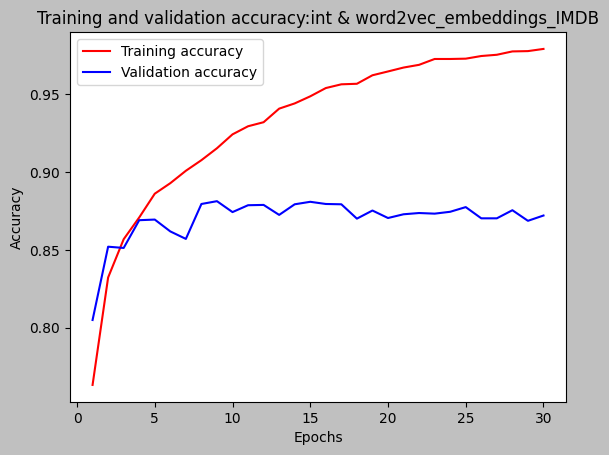

In [ ]:
import matplotlib.pyplot as plt

acc = history_int_word2vec_embeddings_IMDB.history["accuracy"]
val_acc = history_int_word2vec_embeddings_IMDB.history["val_accuracy"]
epochs = range(1, len(val_acc) + 1)
plt.gcf().set_facecolor('silver')
plt.plot(epochs, acc, "r", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy:int & word2vec_embeddings_IMDB")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [ ]:
print(acc)
print(val_acc)

[0.7633500099182129, 0.8322499990463257, 0.8568000197410583, 0.8707500100135803, 0.8859999775886536, 0.8927500247955322, 0.9006999731063843, 0.9075000286102295, 0.915149986743927, 0.924049973487854, 0.9292500019073486, 0.931850016117096, 0.9405500292778015, 0.9438999891281128, 0.9484500288963318, 0.9537500143051147, 0.9561499953269958, 0.9564999938011169, 0.9619500041007996, 0.9643999934196472, 0.9668999910354614, 0.9686499834060669, 0.9724000096321106, 0.9724000096321106, 0.972599983215332, 0.9743000268936157, 0.9750999808311462, 0.9772499799728394, 0.9774500131607056, 0.9788500070571899]
[0.8050000071525574, 0.8519999980926514, 0.8511999845504761, 0.8690000176429749, 0.8694000244140625, 0.8618000149726868, 0.8569999933242798, 0.8794000148773193, 0.8812000155448914, 0.8741999864578247, 0.878600001335144, 0.8787999749183655, 0.8723999857902527, 0.8791999816894531, 0.8808000087738037, 0.8794000148773193, 0.8791999816894531, 0.8700000047683716, 0.8751999735832214, 0.8704000115394592, 0.8

In [ ]:
##val_acc_int_word2vec_embeddings_IMDB = [0.8050000071525574, 0.8519999980926514, 0.8511999845504761, 0.8690000176429749, 0.8694000244140625, 0.8618000149726868, 0.8569999933242798, 0.8794000148773193, 0.8812000155448914, 0.8741999864578247, 0.878600001335144, 0.8787999749183655, 0.8723999857902527, 0.8791999816894531, 0.8808000087738037, 0.8794000148773193, 0.8791999816894531, 0.8700000047683716, 0.8751999735832214, 0.8704000115394592, 0.8727999925613403, 0.8736000061035156, 0.873199999332428, 0.8744000196456909, 0.8773999810218811, 0.870199978351593, 0.870199978351593, 0.8754000067710876, 0.8686000108718872, 0.871999979019165]

# 在不同tokens的編碼及embedding方式下，畫出驗證集的accuracy做比較

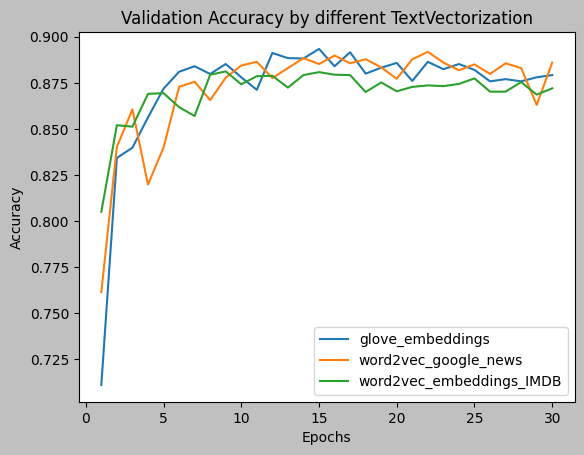

In [ ]:
val_acc_int_glove_embeddings = history_int_glove_embeddings.history["val_accuracy"]
val_acc_int_history_int_word2vec_google_news = history_int_word2vec_google_news.history["val_accuracy"]
val_acc_int_word2vec_embeddings_IMDB = history_int_word2vec_embeddings_IMDB.history["val_accuracy"]

epochs = range(1, 30 + 1)
plt.gcf().set_facecolor('silver')
plt.plot(epochs, val_acc_int_glove_embeddings, label="glove_embeddings")
plt.plot(epochs, val_acc_int_history_int_word2vec_google_news, label="word2vec_google_news")
plt.plot(epochs, val_acc_int_word2vec_embeddings_IMDB, label="word2vec_embeddings_IMDB")

plt.title("Validation Accuracy by different TextVectorization")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Machine Translation by GRU

Step 1.準備翻譯資料spa-eng檔案

In [ ]:
!wget http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip
!unzip -q spa-eng.zip

--2024-06-02 03:55:11--  http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.139.207, 74.125.141.207, 173.194.210.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.139.207|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2638744 (2.5M) [application/zip]
Saving to: ‘spa-eng.zip’

spa-eng.zip         100%[===================>]   2.52M  --.-KB/s    in 0.008s  

2024-06-02 03:55:11 (323 MB/s) - ‘spa-eng.zip’ saved [2638744/2638744]



In [ ]:
text_file = "spa-eng/spa.txt"
with open(text_file) as f:
    lines = f.read().split("\n")[:-1]  ##取得最後一列(空白列)以外的所有資料
text_pairs = []
for line in lines:  ##對文字檔的每一行進行迭代
    english, spanish = line.split("\t")  ##lines中的每一行都包含一個英文短語及相應的西班牙文內容，中間以tab字元隔開
    spanish = "[start] " + spanish + " [end]"  ##我們在西班牙文內容的前方加入[start]字元，並在句子後方加入[end]
    text_pairs.append((english, spanish))

In [ ]:
import random
random.shuffle(text_pairs)
num_val_samples = int(0.15 * len(text_pairs))  ##取15%的資料作為驗證集
num_train_samples = len(text_pairs) - 2 * num_val_samples  ##測試集的樣本數與驗證集相同，據此可算出訓練集的樣本數
train_pairs = text_pairs[:num_train_samples]
val_pairs = text_pairs[num_train_samples:num_train_samples + num_val_samples]
test_pairs = text_pairs[num_train_samples + num_val_samples:]

Step 2.向量化英文和西文的文字組合

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
import string
import re

strip_chars = string.punctuation + "¿"
strip_chars = strip_chars.replace("[", "")
strip_chars = strip_chars.replace("]", "")

def custom_standardization(input_string):  ##自訂一個字串標準化函式，他在去除標點符號時，會保留"["和"]"，並將額外的西班牙文"¿"去除
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(
        lowercase, f"[{re.escape(strip_chars)}]", "")

vocab_size = 15000  ##為求簡單，只處理每種語言的前15000個單字，並將句子限制在20字
sequence_length = 20

source_vectorization = layers.TextVectorization(  ##英文的TextVectorization層
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length,
)
target_vectorization = layers.TextVectorization(  ##西班牙文的TextVectorization層
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length + 1,  ##要多生成一個token，因為在訓練過程中必須讓解碼器預測出的句子向左偏移1步，
                             ##例如輸入"[start] A B"要預測出"A B [end]"
    standardize=custom_standardization,
)
train_english_texts = [pair[0] for pair in train_pairs]
train_spanish_texts = [pair[1] for pair in train_pairs]
source_vectorization.adapt(train_english_texts)  ##學習兩種語言的詞彙表。adapt()使用方法 page:11-12
target_vectorization.adapt(train_spanish_texts)

Step 3.為翻譯任務準備資料集

In [ ]:
batch_size = 64

def format_dataset(eng, spa):
    eng = source_vectorization(eng)
    spa = target_vectorization(spa)
    return ({
        "english": eng,  ##inputs是有兩個key的Python字典
        "spanish": spa[:, :-1],  ##inputs中的西班文句子不包括最後一個token，以讓inputs和targets中的句子保持相同長度
    }, spa[:, 1:])  ##targets中的西文句子會往左偏移一步(去掉[start])，兩者的長度仍然相同(20個單字)

def make_dataset(pairs):  ##輸入的pairs須為list格式，在train_pairs中，每筆資料為list(英文句子，西班牙文句子)
    eng_texts, spa_texts = zip(*pairs)  ##利用"*"符號將pairs解包成eng_texts, spa_texts句子
    eng_texts = list(eng_texts)  ##將eng_texts數據格式tuple轉為串列
    spa_texts = list(spa_texts)  ##將spa_texts數據格式tuple轉為串列
    dataset = tf.data.Dataset.from_tensor_slices((eng_texts, spa_texts))  ##創建一個tf.data.Dataset對象
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(format_dataset, num_parallel_calls=4)
    return dataset.shuffle(2048).prefetch(16).cache()  ##用記憶體內的快取來提升預先處理的速度

train_ds = make_dataset(train_pairs)
val_ds = make_dataset(val_pairs)

Step 4.使用GRU編碼器

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

embed_dim = 256
latent_dim = 1024

source = keras.Input(shape=(None,), dtype="int64", name="english")  ##source為英文原句，此處指定了Input物件的名稱(english)，以便能將輸入資料以
                                     ##Python字典的形式傳入fit()
x = layers.Embedding(vocab_size, embed_dim, mask_zero=True)(source)  ##設定遮罩，遮掉0值
encoded_source = layers.Bidirectional(  ##雙向GRU的最終輸出就是原句的編碼結果
    layers.GRU(latent_dim), merge_mode="sum")(x)  ##merge_mode="sum"==>加總正向處理序列以及反向處理序列的結果

Step 5.使用GRU解碼器及端到端模型

In [ ]:
past_target = keras.Input(shape=(None,), dtype="int64", name="spanish")  ##past_target為西班牙文目標句
x = layers.Embedding(vocab_size, embed_dim, mask_zero=True)(past_target)  ##此處同樣要使用遮罩
decoder_gru = layers.GRU(latent_dim, return_sequences=True)
x = decoder_gru(x, initial_state=encoded_source)  ##原句的編碼結果為解碼器GRU的初始狀態
x = layers.Dropout(0.5)(x)
target_next_step = layers.Dense(vocab_size, activation="softmax")(x)  ##預測下一個token的機率分布
seq2seq_rnn = keras.Model([source, past_target], target_next_step)  ##端到端模型:將原始句子跟目標句子對應到左移一位的目標句子
                                     ##因此每個token都會對應到其下一個token

Step 6.訓練循環Seq2seq模型

In [ ]:
seq2seq_rnn.compile(
    optimizer="rmsprop",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"])

history_seq2seq_gru = seq2seq_rnn.fit(train_ds, epochs=30, validation_data=val_ds)  ##原程式碼epochs為15

Epoch 1/30
1302/1302 [==============================] - 71s 45ms/step - loss: 4.6837 - accuracy: 0.3188 - val_loss: 3.9519 - val_accuracy: 0.3792
Epoch 2/30
1302/1302 [==============================] - 50s 38ms/step - loss: 3.7239 - accuracy: 0.4145 - val_loss: 3.2471 - val_accuracy: 0.4640
Epoch 3/30
1302/1302 [==============================] - 50s 38ms/step - loss: 3.2147 - accuracy: 0.4717 - val_loss: 2.8789 - val_accuracy: 0.5132
Epoch 4/30
1302/1302 [==============================] - 50s 38ms/step - loss: 2.8636 - accuracy: 0.5127 - val_loss: 2.6478 - val_accuracy: 0.5443
Epoch 5/30
1302/1302 [==============================] - 50s 38ms/step - loss: 2.5901 - accuracy: 0.5452 - val_loss: 2.4444 - val_accuracy: 0.5751
Epoch 6/30
1302/1302 [==============================] - 50s 38ms/step - loss: 2.3679 - accuracy: 0.5736 - val_loss: 2.3123 - val_accuracy: 0.5960
Epoch 7/30
1302/1302 [==============================] - 50s 38ms/step - loss: 2.1855 - accuracy: 0.5974 - val_loss: 2.2169 -

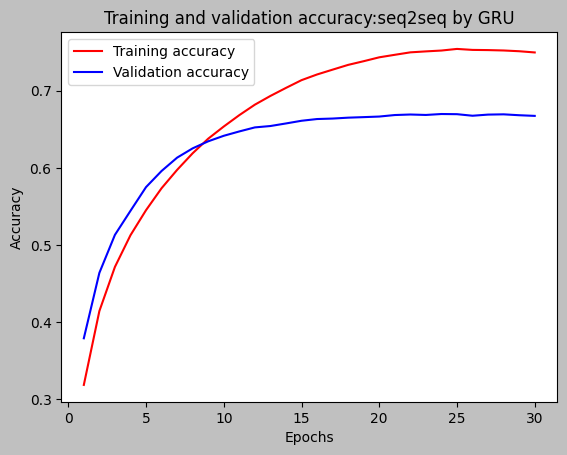

In [ ]:
####################畫出train data及validation data的accuarcy####################
import matplotlib.pyplot as plt

acc = history_seq2seq_gru.history["accuracy"]
val_acc = history_seq2seq_gru.history["val_accuracy"]
epochs = range(1, len(val_acc) + 1)
plt.gcf().set_facecolor('silver')
plt.plot(epochs, acc, "r", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy:seq2seq by GRU")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [ ]:
print(acc)
print(val_acc)

[0.3187582790851593, 0.4144737124443054, 0.4716581404209137, 0.5127119421958923, 0.5451737642288208, 0.5736225843429565, 0.5974032282829285, 0.6189374327659607, 0.6378344893455505, 0.6535803079605103, 0.668323278427124, 0.6818865537643433, 0.6931989192962646, 0.703607976436615, 0.7136425971984863, 0.7210103869438171, 0.7272652983665466, 0.7334414720535278, 0.7382166385650635, 0.7432458400726318, 0.7464995980262756, 0.7496820688247681, 0.750925600528717, 0.7520265579223633, 0.7541199326515198, 0.7528466582298279, 0.7526059746742249, 0.752099335193634, 0.7511231899261475, 0.7495453357696533]
[0.37917953729629517, 0.46395498514175415, 0.5131890773773193, 0.5443259477615356, 0.5750598907470703, 0.595963716506958, 0.6132411956787109, 0.6253013014793396, 0.6344159245491028, 0.6415644884109497, 0.6472055315971375, 0.6524297595024109, 0.6542220711708069, 0.6575497388839722, 0.6610302329063416, 0.663267195224762, 0.6638994216918945, 0.6650456786155701, 0.665747344493866, 0.6664906740188599, 0.6

Step 7.用RNN編碼器和解碼器翻譯新的句子

In [ ]:
import numpy as np
spa_vocab = target_vectorization.get_vocabulary()
spa_index_lookup = dict(zip(range(len(spa_vocab)), spa_vocab))  ##準備一個字典，用來將預測出的token由索引值轉換為字串
max_decoded_sentence_length = 20

def decode_sequence(input_sentence):
    tokenized_input_sentence = source_vectorization([input_sentence])
    decoded_sentence = "[start]"  ##種子token
    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = target_vectorization([decoded_sentence])
        next_token_predictions = seq2seq_rnn.predict(
            [tokenized_input_sentence, tokenized_target_sentence])
        sampled_token_index = np.argmax(next_token_predictions[0, i, :])  ##取樣下一個token(選擇機率最大的token)
        sampled_token = spa_index_lookup[sampled_token_index]  ##將下一個token的預測結果(為一索引)轉換為字串，並把他append到生成的句子中
        decoded_sentence += " " + sampled_token
        if sampled_token == "[end]":  ##結束條件:取樣到代表停止的字元([end])，或達到最大的長度(max_decoded_sentence_length)
            break
    return decoded_sentence

test_eng_texts = [pair[0] for pair in test_pairs]
for _ in range(20):
    input_sentence = random.choice(test_eng_texts)
    print("-")
    print(input_sentence)
    print(decode_sequence(input_sentence))

-
The French were defeated at Waterloo.
1/1 [==============================] - 0s 22ms/step
[start] los zapatos fueron [UNK] en [UNK] [end]
-
It seems that he knows everything.
1/1 [==============================] - 0s 22ms/step
[start] parece que él sabe todo [end]
-
I'll call you if I need you.
1/1 [==============================] - 0s 23ms/step
[start] te llamaré si te lo quiero [end]
-
You must do it yourself.
1/1 [==============================] - 0s 23ms/step
[start] tienes que hacerlo tú mismo [end]
-
I already know.
1/1 [==============================] - 0s 23ms/step
[start] ya yo sé [end]
-
This is very important meeting. You ought not to miss it.
1/1 [==============================] - 0s 23ms/step
[start] esta es una buena idea de que no [UNK] a la [UNK] [end]
-
It'll be impossible to get a visa on short notice.
1/1 [==============================] - 0s 23ms/step
[start] será imposible [UNK] de una salud [UNK] por la salud [end]
-
Where is the mailbox?
1/1 [==================

# Machine Translation by Transformer

Step 1.建立transformer Encoder

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"),
             layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()

    def call(self, inputs, mask=None):
        if mask is not None:
            mask = mask[:, tf.newaxis, :]
        attention_output = self.attention(
            inputs, inputs, attention_mask=mask)
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim,
        })
        return config

Step 2.建立Positional Embedding

In [ ]:
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, input_dim, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=input_dim, output_dim=output_dim)
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=output_dim)
        self.sequence_length = sequence_length
        self.input_dim = input_dim
        self.output_dim = output_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)

    def get_config(self):
        config = super(PositionalEmbedding, self).get_config()
        config.update({
            "output_dim": self.output_dim,
            "sequence_length": self.sequence_length,
            "input_dim": self.input_dim,
        })
        return config

Step 3.建立Transformer Dencoder

In [ ]:
class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"),
             layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.supports_masking = True  ##這個屬性確保神經層會把他的輸入遮罩傳播到他的輸出，keras中的遮罩是要手動設定的。如果把遮罩傳遞給一個
                         ##不包含compute_mask()方法且沒有supports_masking屬性的層，就會出現錯誤

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim,
        })
        return config

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")  ##生成shape為(sequence_length，sequence_length)的矩陣，其元素值可為0或1
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1),
             tf.constant([1, 1], dtype=tf.int32)], axis=0)
                         ##沿著批量軸複製，得到一個shape為(batch_size，sequence_length,batch_size，sequence_length)的矩陣
        return tf.tile(mask, mult)

    def call(self, inputs, encoder_outputs, mask=None):
        causal_mask = self.get_causal_attention_mask(inputs)  ##取得因果遮罩
        if mask is not None:  ##準備輸入遮罩(用來表示目標序列中的填補位置)
            padding_mask = tf.cast(
                mask[:, tf.newaxis, :], dtype="int32")
            padding_mask = tf.minimum(padding_mask, causal_mask)
              ##合併兩個遮罩，對padding_mask和casual_mask進行逐元素比較，取得相應位置的最小值，並存放在新的張量中，
              ##新張量的shape與padding_mask和casual_mask的shape相同
        attention_output_1 = self.attention_1(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=causal_mask)  ##將因果遮罩傳遞給第一個attention層，該層會對目標序列執行self-attention
        attention_output_1 = self.layernorm_1(inputs + attention_output_1)
        attention_output_2 = self.attention_2(
            query=attention_output_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,  ##把合併遮罩傳遞給第二個attention層，該層會尋找原始序列與目標序列間的關聯性
        )
        attention_output_2 = self.layernorm_2(
            attention_output_1 + attention_output_2)
        proj_output = self.dense_proj(attention_output_2)
        return self.layernorm_3(attention_output_2 + proj_output)

Step 4.端到端Transformer

In [ ]:
embed_dim = 256
dense_dim = 2048
num_heads = 8

encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="english")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(encoder_inputs)
encoder_outputs = TransformerEncoder(embed_dim, dense_dim, num_heads)(x)  ##對原句進行編碼

decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="spanish")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(decoder_inputs)
x = TransformerDecoder(embed_dim, dense_dim, num_heads)(x, encoder_outputs)  ##對目標句進行處理，並將其與編碼過的原句結合
x = layers.Dropout(0.5)(x)
decoder_outputs = layers.Dense(vocab_size, activation="softmax")(x)  ##為每個輸出位置預測出一個單字(token)的機率分布
transformer = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)

Step 5.訓練Seq2seq Transformer

In [ ]:
transformer.compile(
    optimizer="rmsprop",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"])

history_seq2seq_transformer = transformer.fit(train_ds, epochs=30, validation_data=val_ds)

Epoch 1/30
1302/1302 [==============================] - 100s 71ms/step - loss: 3.7923 - accuracy: 0.4408 - val_loss: 2.8797 - val_accuracy: 0.5379
Epoch 2/30
1302/1302 [==============================] - 88s 68ms/step - loss: 2.8493 - accuracy: 0.5503 - val_loss: 2.5389 - val_accuracy: 0.5865
Epoch 3/30
1302/1302 [==============================] - 88s 68ms/step - loss: 2.5547 - accuracy: 0.5939 - val_loss: 2.3796 - val_accuracy: 0.6137
Epoch 4/30
1302/1302 [==============================] - 88s 68ms/step - loss: 2.3934 - accuracy: 0.6199 - val_loss: 2.3407 - val_accuracy: 0.6254
Epoch 5/30
1302/1302 [==============================] - 88s 68ms/step - loss: 2.2900 - accuracy: 0.6381 - val_loss: 2.3165 - val_accuracy: 0.6303
Epoch 6/30
1302/1302 [==============================] - 88s 68ms/step - loss: 2.2187 - accuracy: 0.6516 - val_loss: 2.2949 - val_accuracy: 0.6361
Epoch 7/30
1302/1302 [==============================] - 88s 68ms/step - loss: 2.1624 - accuracy: 0.6632 - val_loss: 2.3003 

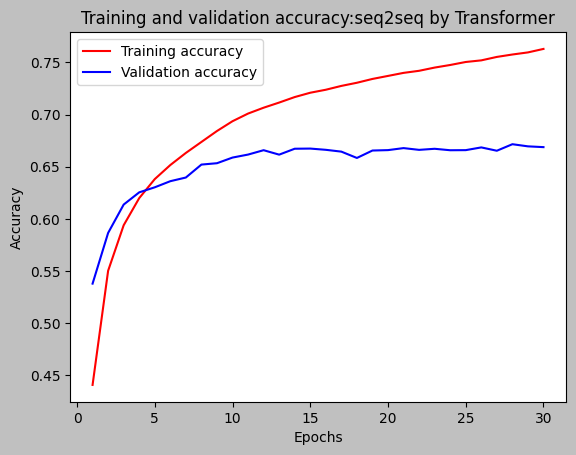

In [ ]:
####################畫出train data及validation data的accuarcy####################
import matplotlib.pyplot as plt

acc = history_seq2seq_transformer.history["accuracy"]
val_acc = history_seq2seq_transformer.history["val_accuracy"]
epochs = range(1, len(val_acc) + 1)
plt.gcf().set_facecolor('silver')
plt.plot(epochs, acc, "r", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy:seq2seq by Transformer")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [ ]:
print(acc)
print(val_acc)

[0.4408304989337921, 0.5502529144287109, 0.5938831567764282, 0.6198945641517639, 0.6381177306175232, 0.6515967845916748, 0.6632062196731567, 0.6737185716629028, 0.6842041015625, 0.6936014890670776, 0.7009342312812805, 0.7065476775169373, 0.7114867568016052, 0.7167518734931946, 0.7209020256996155, 0.7237675189971924, 0.7274457812309265, 0.7304676175117493, 0.7341265678405762, 0.7370203137397766, 0.7399334907531738, 0.7419266700744629, 0.7450169920921326, 0.747499942779541, 0.7503758668899536, 0.751928448677063, 0.7552271485328674, 0.7575418949127197, 0.7595559358596802, 0.762897789478302]
[0.5379185676574707, 0.5865148901939392, 0.613700270652771, 0.625422477722168, 0.6302529573440552, 0.6361106038093567, 0.6396363377571106, 0.6520387530326843, 0.6533365845680237, 0.6587569713592529, 0.6616302728652954, 0.6658222675323486, 0.6615608930587769, 0.6672242283821106, 0.6673768758773804, 0.6661900877952576, 0.664448082447052, 0.6583821773529053, 0.6655030250549316, 0.6658986210823059, 0.66782

Srep 6.用Transformer模型翻譯新句子

In [ ]:
import numpy as np
spa_vocab = target_vectorization.get_vocabulary()
spa_index_lookup = dict(zip(range(len(spa_vocab)), spa_vocab))
max_decoded_sentence_length = 20

def decode_sequence(input_sentence):
    tokenized_input_sentence = source_vectorization([input_sentence])
    decoded_sentence = "[start]"
    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = target_vectorization(
            [decoded_sentence])[:, :-1]
        predictions = transformer(  ##取樣下一個token(選擇機率最大的token)
            [tokenized_input_sentence, tokenized_target_sentence])
        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = spa_index_lookup[sampled_token_index]  ##將下一個token的預測結果(為一索引)轉換成字串，並把他append到生成的句子中
        decoded_sentence += " " + sampled_token
        if sampled_token == "[end]":
            break
    return decoded_sentence

test_eng_texts = [pair[0] for pair in test_pairs]
for _ in range(20):
    input_sentence = random.choice(test_eng_texts)
    print("-")
    print(input_sentence)
    print(decode_sequence(input_sentence))

-
I want to spend some time with you.
[start] quiero pasar tiempo contigo [end]
-
It takes time.
[start] hace tiempo [end]
-
The roses in the garden are blooming.
[start] la enfermedad del jardín está [UNK] [end]
-
Is Tom lucid?
[start] tom está [UNK] [end]
-
Stop pushing.
[start] deja de [UNK] [end]
-
Life resembles a novel more often than novels resemble life.
[start] la vida se ve a menudo que se ve la vida que a menudo [end]
-
If I were you, I'd follow his advice.
[start] si fuera tú [UNK] su consejo [end]
-
How long do you think it will take to go to the airport?
[start] cuánto tiempo crees que va a ir al aeropuerto [end]
-
I took a bath.
[start] yo te pude usar un baño [end]
-
It's part of the job.
[start] es parte del trabajo [end]
-
Are you going to buy the car?
[start] vas a comprar el coche [end]
-
In the 6th century, the Anglo-Saxons adopted Roman characters.
[start] en el extranjero me [UNK] de [UNK] las [UNK] [end]
-
She is not only intelligent but beautiful.
[start] ella 

# Text Generation

Step 1.下載並解壓縮IMDB影評資料集

In [ ]:
!wget https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xf aclImdb_v1.tar.gz

--2024-06-01 10:30:56--  https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84125825 (80M) [application/x-gzip]
Saving to: ‘aclImdb_v1.tar.gz.1’

aclImdb_v1.tar.gz.1 100%[===================>]  80.23M  7.36MB/s    in 17s     

2024-06-01 10:31:13 (4.71 MB/s) - ‘aclImdb_v1.tar.gz.1’ saved [84125825/84125825]



In [ ]:
import tensorflow as tf
from tensorflow import keras
dataset = keras.utils.text_dataset_from_directory(
    directory="aclImdb", label_mode=None, batch_size=256)
dataset = dataset.map(lambda x: tf.strings.regex_replace(x, "<br />", " "))

Found 105006 files belonging to 1 classes.


In [ ]:
from tensorflow.keras.layers import TextVectorization

sequence_length = 100
vocab_size = 15000
text_vectorization = TextVectorization(
    max_tokens=vocab_size,  ##只考慮前15000個最常見的單字，其他的都將被視為詞彙表外的token，也就是[UNK]
    output_mode="int",  ##傳回單字的整數索引序列
    output_sequence_length=sequence_length,  ##使用長度為100的輸入序列和目標序列(但由於我們會把目標序列往左偏移1步，所以模型實際看到的會是長度為
                          ##99的目標序列內容)
)
text_vectorization.adapt(dataset)  ##計算詞彙表

In [ ]:
def prepare_lm_dataset(text_batch):
    vectorized_sequences = text_vectorization(text_batch)  ##將一批次的文字(字串)轉換成一批次的整數序列
    x = vectorized_sequences[:, :-1]  ##丟棄整數序列的最後1個單字向量來創建輸入序列
    y = vectorized_sequences[:, 1:]  ##將整數序列往左偏移1步(丟棄第1個單字向量)來創建目標序列
    return x, y

lm_dataset = dataset.map(prepare_lm_dataset, num_parallel_calls=4)  ##平行處理

Step 2.建立Transformer的Positional Embedding層及Transformer Decoder層

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, input_dim, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=input_dim, output_dim=output_dim)
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=output_dim)
        self.sequence_length = sequence_length
        self.input_dim = input_dim
        self.output_dim = output_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)

    def get_config(self):
        config = super(PositionalEmbedding, self).get_config()
        config.update({
            "output_dim": self.output_dim,
            "sequence_length": self.sequence_length,
            "input_dim": self.input_dim,
        })
        return config


class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
          num_heads=num_heads, key_dim=embed_dim)
        self.attention_2 = layers.MultiHeadAttention(
          num_heads=num_heads, key_dim=embed_dim)
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"),
             layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.supports_masking = True

    def get_config(self):
        config = super(TransformerDecoder, self).get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim,
        })
        return config

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1),
             tf.constant([1, 1], dtype=tf.int32)], axis=0)
        return tf.tile(mask, mult)

    def call(self, inputs, encoder_outputs, mask=None):
        causal_mask = self.get_causal_attention_mask(inputs)
        if mask is not None:
            padding_mask = tf.cast(
                mask[:, tf.newaxis, :], dtype="int32")
            padding_mask = tf.minimum(padding_mask, causal_mask)
        attention_output_1 = self.attention_1(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=causal_mask)
        attention_output_1 = self.layernorm_1(inputs + attention_output_1)
        attention_output_2 = self.attention_2(
            query=attention_output_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
        )
        attention_output_2 = self.layernorm_2(
            attention_output_1 + attention_output_2)
        proj_output = self.dense_proj(attention_output_2)
        return self.layernorm_3(attention_output_2 + proj_output)

Step 3.建立Transformer語言模型

In [ ]:
from tensorflow.keras import layers
embed_dim = 256
latent_dim = 2048
num_heads = 2

inputs = keras.Input(shape=(None,), dtype="int64")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(inputs)
x = TransformerDecoder(embed_dim, latent_dim, num_heads)(x, x)
outputs = layers.Dense(vocab_size, activation="softmax")(x)  ##針對每個輸出序列時步，使用softmax計算單字的機率分佈
model = keras.Model(inputs, outputs)
model.compile(loss="sparse_categorical_crossentropy", optimizer="rmsprop")

In [ ]:
import numpy as np

tokens_index = dict(enumerate(text_vectorization.get_vocabulary()))  ##建立一個Python字典以用於文字解碼(key為單字的索引，value為對應的單字字串)

def sample_next(predictions, temperature=1.0):  ##從機率分佈中使用給定的temperature來取樣
    predictions = np.asarray(predictions).astype("float64")
    predictions = np.log(predictions) / temperature
    exp_preds = np.exp(predictions)
    predictions = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, predictions, 1)
    return np.argmax(probas)

Step 4.建立文字生成的callback物件

In [ ]:
class TextGenerator(keras.callbacks.Callback):
    def __init__(self,
                 prompt,  ##做為文字生成種子的提示
                 generate_length,  ##要生成的單字數量
                 model_input_length,
                 temperatures=(1.,),  ##要用來取樣的一或多個temperature(放在tuple中)
                 print_freq=1):
        self.prompt = prompt
        self.generate_length = generate_length
        self.model_input_length = model_input_length
        self.temperatures = temperatures
        self.print_freq = print_freq

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.print_freq != 0:
            return
        for temperature in self.temperatures:
            print("== Generating with temperature", temperature)
            sentence = self.prompt  ##生成文字時，會以提示token做為起始token
            for i in range(self.generate_length):
                tokenized_sentence = text_vectorization([sentence])  ##將當前序列(會先經過向量化)餵入模型，並取得輸出的預測序列
                predictions = self.model(tokenized_sentence)
                next_token = sample_next(predictions[0, i, :])  ##取得最後一個時步i的預測結果，並查字典將之轉換為單字
                sampled_token = tokens_index[next_token]
                sentence += " " + sampled_token  ##把新單字append到當前序列
            print(sentence)

prompt = "This movie"
text_gen_callback = TextGenerator(  ##創建一個callback物件
    prompt,
    generate_length=50,
    model_input_length=sequence_length,
    temperatures=(0.2, 0.5, 0.7, 1., 1.5))  ##使用多種temperature來取樣文字，藉此呈現temperature對文字生成的影響

Step 5.訓練語言模型

In [ ]:
history_seq2seq_text_generation = model.fit(lm_dataset, epochs=30, callbacks=[text_gen_callback])

Epoch 1/30
411/411 [==============================] - ETA: 0s - loss: 5.6400== Generating with temperature 0.2
This movie movie is started a lost 999 swords make recognizes this in movie this 2 movie maybe it however is i quite have acted changed well family i colin would era like and characters raunchy seem talent more [UNK] saw as it usual was desperately good or film offered target the
== Generating with temperature 0.5
This movie was was crossed that despite has it many turned years into ago a during movie my which girlfriend was everyone lucky who stefan else i movies am for adequate disappointed very by long the typical very comedy intense i words satisfaction hard drink the its first just their better [UNK]
== Generating with temperature 0.7
This movie should is tell a you effort think there they something will taylors cried one if of youre charm a when quirky gordon than mackenzie any those version istanbul of british that mediocrity suspects [UNK] i a blame close you brand wan

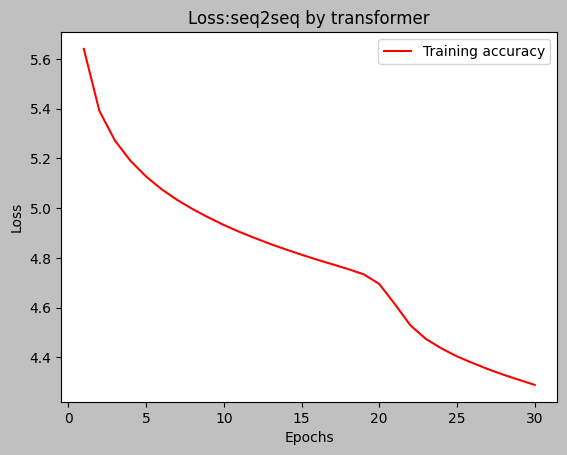

In [ ]:
####################畫出訓練的loss####################
import matplotlib.pyplot as plt

loss = history_seq2seq_text_generation.history["loss"]
epochs = range(1, len(val_acc) + 1)
plt.gcf().set_facecolor('silver')
plt.plot(epochs, loss, "r", label="Training accuracy")
plt.title("Loss:seq2seq by transformer")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
print(history_seq2seq_text_generation.history["loss"])

[5.640012264251709, 5.391064643859863, 5.271987438201904, 5.190245628356934, 5.1273016929626465, 5.07619571685791, 5.033308029174805, 4.996175765991211, 4.963062763214111, 4.932597637176514, 4.904934883117676, 4.879887580871582, 4.855848789215088, 4.834005832672119, 4.812972068786621, 4.792978286743164, 4.77413272857666, 4.755102634429932, 4.734127521514893, 4.695446014404297, 4.614682674407959, 4.529386043548584, 4.474350452423096, 4.436235427856445, 4.404253959655762, 4.377713203430176, 4.352816581726074, 4.330318927764893, 4.309754848480225, 4.289559841156006]
